In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../../fast_two_stage_psf_correction/")
from pathlib import Path
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms.v2.functional as TF

In [3]:
from fast_optics_correction import OpticsCorrection
from fast_optics_correction import utils, filters

Initialize model and inference function

In [22]:
device = "cpu"
model = OpticsCorrection(
    patch_size=400, 
    overlap_percentage=0.25,
    ker_size=25, 
    batch_size=32
)
model = model.to(device)

In [23]:
def eboli_img_correction(img_path, model, device):
    img = cv2.imread(img_path)
    img = img.astype(np.float32) / 255
    img = np.clip(img, a_min=1e-8, a_max=1.0) ** 2.2   # Linearize the srgb image
    # Inference
    img = utils.to_tensor(img).unsqueeze(0)  # Define the array on the CPU! (important for larger images)
    img = img.to(device)
    with torch.no_grad():
        img_corrected, kernels = model(
            img, 
            sigma_b=0.358, 
            c=0.416, 
            q=0.0001,
            polyblur_iteration=3, 
            alpha=6, 
            b=1,
            do_decomposition=True,
            do_halo_removal=True,
            do_edgetaper=True, 
            sigma_s=200, 
            sigma_r=0.1
        )
    img_corrected = utils.to_array(img_corrected.cpu())
    ## Gamma curve as simple ISP
    img_corrected_out = np.clip(img_corrected, a_min=1e-8, a_max=1.0) ** (1./2.2)
    return img_corrected_out * 255, kernels

## Reconstruction

Run reconstruction on all f/16 images

In [24]:
out_path = Path("../data/parkinglot_reconstruction/eboli").resolve()
out_path.mkdir(exist_ok=True)
input_paths = [
    "P1081841_f16.0.png",
    "P1081842_f16.0.png",
    "P1081847_f16.0.png",
    "P1081848_f16.0.png",
    "P1081853_f16.0.png",
    "P1081854_f16.0.png",
    "P1081859_f16.0.png",
    "P1081866_f16.0.png",
    "P1081872_f16.0.png",
    "P1081878_f16.0.png",
    "P1081883_f16.0.png",
    "P1081884_f16.0.png",
    "P1081891_f16.0.png",
    "P1081892_f16.0.png",
    "P1081922_f16.0.png",
    "P1081927_f16.0.png",
    "P1081935_f16.0.png",
    "P1081946_f16.0.png",
    "P1081949_f16.0.png",
    "P1081954_f16.0.png",
    "P1081956_f16.0.png",
    "P1081961_f16.0.png",
]
input_paths = [Path("./camera_day3/png") / im_path for im_path in input_paths]
len(input_paths)

22

In [25]:
for img_path in input_paths:
    corrected_img, _ = eboli_img_correction(img_path, model, device)
    cv2.imwrite(out_path / (img_path.stem + "_corrected.png"), corrected_img)

Inference on device cpu:
Deblurring method is: fft
Init:             0.001
There are 4 frames
Processing frame 0 of size torch.Size([1, 3, 1952, 2600])
stride=(300, 300)
padding=(24, 24, 100, 100)
window_size=(400, 400)
Total patches: patches.shape=torch.Size([54, 3, 400, 400])
n=0 patch.shape=torch.Size([32, 3, 400, 400])
Decompostion:     1.235
kernel.shape=torch.Size([32, 3, 25, 25])
Estimation 1:     1.222
Deblurring 1:     2.608
kernel.shape=torch.Size([32, 3, 25, 25])
Estimation 2:     1.290
Deblurring 2:     2.650
kernel.shape=torch.Size([32, 3, 25, 25])
Estimation 3:     1.199
Deblurring 3:     2.726
Defringing:       11.482
n=1 patch.shape=torch.Size([22, 3, 400, 400])
Decompostion:     0.646
kernel.shape=torch.Size([22, 3, 25, 25])
Estimation 1:     0.914
Deblurring 1:     2.221
kernel.shape=torch.Size([22, 3, 25, 25])
Estimation 2:     0.994
Deblurring 2:     2.297
kernel.shape=torch.Size([22, 3, 25, 25])
Estimation 3:     0.964
Deblurring 3:     2.298
Defringing:       8.60

### Kernels

In [10]:
import kornia.contrib

(24, 24, 100, 100)

In [ ]:
img_path = Path("./camera_day3/png/P1081853_f16.0.png")

In [ ]:
_, kernels = eboli_img_correction(str(img_path), model, device)

In [34]:
tot_kernel_batches = len(kernels)
per_frame_kernel_batches = tot_kernel_batches // 4
frame_size = [1952, 2600]
patch_size = 400
overlap = 0.25
stride = (int(patch_size * (1-overlap)), int(patch_size * (1-overlap)))
padding = kornia.contrib.compute_padding(frame_size, (patch_size, patch_size))
frame_size = [frame_size[0] + padding[0] + padding[1], frame_size[1] + padding[2] + padding[3]]
frame_patches_y = frame_size[0] // stride[0]
frame_patches_x = frame_size[1] // stride[1]
all_frame_kernels = []
for frame_idx in range(4):  # frames are top-left, top-right, bottom-left, bottom-right
    per_frame_kernels = kernels[frame_idx * per_frame_kernel_batches: (frame_idx + 1) * per_frame_kernel_batches]
    per_frame_kernels = torch.cat(per_frame_kernels, dim=0)
    per_frame_kernels = per_frame_kernels[2::3]  # one every 3 (number of polyblur iterations)
    per_frame_kernels = per_frame_kernels.view(frame_patches_y, frame_patches_x, *per_frame_kernels.shape[1:])
    # per_frame_kernels = per_frame_kernels.view(frame_patches_x, frame_patches_y, *per_frame_kernels.shape[1:])
    # per_frame_kernels = per_frame_kernels.transpose(0, 1)
    all_frame_kernels.append(per_frame_kernels)
all_kernels = torch.cat(
    [torch.cat([all_frame_kernels[0], all_frame_kernels[1]], dim=1),
    torch.cat([all_frame_kernels[2], all_frame_kernels[3]], dim=1)],
    dim=0
)
all_kernels = TF.center_crop(all_kernels, [7, 7])
nh, nw, c, h, w = all_kernels.shape
all_kernels = torch.einsum("nmchw->cnhmw", all_kernels).reshape(c, nh*h, nw*w)
all_kernels.shape

torch.Size([3, 84, 126])

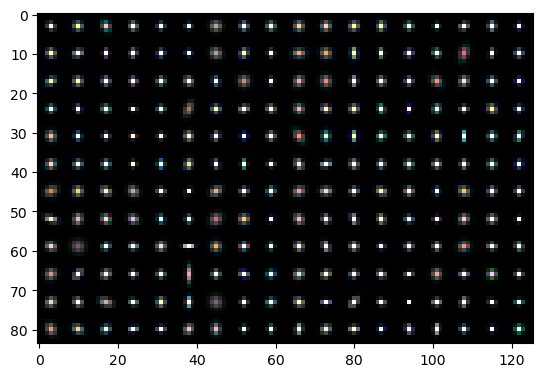

In [35]:
fig, ax = plt.subplots()#ncols=4, figsize=(12, 3))
ax.imshow(all_kernels.permute(1, 2, 0) * 3)

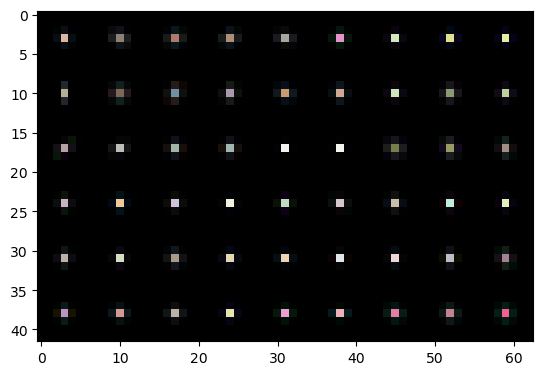

In [35]:
fig, ax = plt.subplots()#ncols=4, figsize=(12, 3))
kernel_crop = TF.center_crop(kernels, [7, 7])
ks = kernel_crop.shape[-1]
kernel_grid = kernel_crop.view(6, 9, 3, ks, ks).permute(0, 3, 1, 4, 2).reshape(6*ks, 9*ks, 3)
ax.imshow(kernel_grid)

In [36]:
## Gamma curve as simple ISP
img_out = np.clip(img, a_min=1e-8, a_max=1.0) ** (1./2.2)
img_corrected_out = np.clip(img_corrected, a_min=1e-8, a_max=1.0) ** (1./2.2)

In [38]:
img_name = input_image_path.stem
torch.save(kernels, f"/home/gmeanti/inria/inverseproblems/notebooks/camera_reconstruction/{img_name}_kernels.pt")
cv2.imwrite(f"/home/gmeanti/inria/inverseproblems/notebooks/camera_reconstruction/{img_name}_corrected.png", img_corrected_out * 255)
cv2.imwrite(f"/home/gmeanti/inria/inverseproblems/notebooks/camera_reconstruction/{img_name}_original.png", img_out * 255)

True

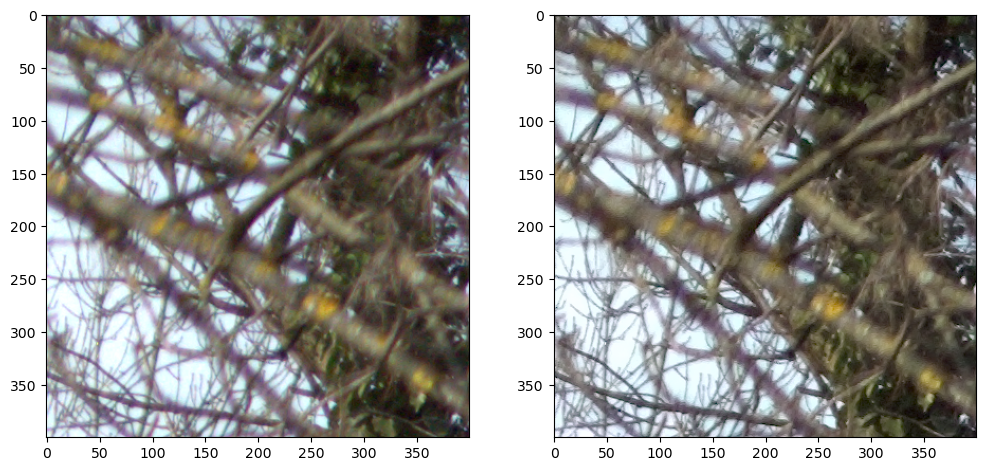

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(img_out[:, :, ::-1])
ax[1].imshow(img_corrected_out[:, :, ::-1])